In [4]:
import udma
import numpy as np
import fxpmath as fx
import matplotlib.pyplot as plt
from tqdm import trange

In [5]:
cb = udma.UDMA_CLASS('192.168.1.10', 7)
cb.connect()
cb.log(0)

[(5,), 0]

In [6]:
cb.write_reg(0, 1)
cb.write_reg(0, 0)

[(1, 0), 0]

In [7]:
for i in trange(1):
    x = np.random.randint(0,32767)
    cb.write_fifo(1, [x])
    #print(x)
    while (cb.read_reg(1)[1][0] & 1 == 0):
        pass

100%|██████████| 1/1 [00:00<00:00, 23.83it/s]


In [8]:
hw_data = []
for i in trange(100):
    x = np.random.randint(0,32767)
    cb.write_fifo(1, [x])
    #print(x)
    while (cb.read_reg(1)[1][0] & 1 == 0):
        pass
    hw_data.append(cb.read_reg(0)[1][0])


100%|██████████| 100/100 [00:08<00:00, 12.15it/s]


In [9]:
print(hw_data)

[57, 14, 12, 13, 41, 32, 45, 9, 2, 62, 33, 36, 15, 49, 9, 34, 8, 47, 34, 60, 4, 62, 6, 31, 28, 6, 8, 11, 59, 1, 2, 55, 3, 26, 61, 2, 32, 46, 27, 56, 53, 6, 47, 11, 50, 11, 20, 40, 27, 20, 52, 22, 51, 56, 60, 59, 47, 53, 59, 20, 13, 10, 57, 5, 26, 2, 3, 58, 60, 15, 37, 54, 29, 3, 24, 25, 7, 24, 59, 20, 40, 37, 28, 9, 46, 42, 26, 25, 9, 45, 8, 47, 35, 10, 39, 61, 27, 47, 14, 15]


In [10]:
# AGENTS
class Agent:
    def __init__(self, n_anctions, alfa):
        self.alfa = alfa
        self.n_anctions = n_anctions
        self.indices = np.arange(n_anctions)
        self.prob = np.ones(self.n_anctions) / self.n_anctions
    def step(self, action, reward):    
        self.prob = (1 - self.alfa * reward) * self.prob
        self.prob[action] += self.alfa * reward
    def act(self):
        return np.random.choice(self.indices, p=self.prob)

In [11]:
# QUANTUM
def general1qgate(a,b,c):
    u2 = np.matrix([[             np.cos(a/2), -np.exp(1j*c)    *np.sin(a/2)],
                    [np.exp(1j*b)*np.sin(a/2),  np.exp(1j*(b+c))*np.cos(a/2)]])
    return u2

def Numpy_QGT_Nplayers(tipo, J_init, J_dg):
    n_p = len(tipo)
    strategies_gate = 1
    for i in range(n_p):      
      players_gate = general1qgate(tipo[i][0], tipo[i][1], tipo[i][2])
      strategies_gate = np.kron(strategies_gate, players_gate)
    outputstate = J_dg * strategies_gate * J_init
    prob = np.power(np.abs(outputstate),2)
    return prob

def matrix_reward(rotat, J_init, J_dg):  
  prob = Numpy_QGT_Nplayers(rotat, J_init, J_dg)
  reward_g = prob.transpose() * game
  reward_h = reward_g.tolist()[0]
  return reward_h

# GAME
def int_to_binary(s,m):
    if s == 0:
        return "0 " * m
    binary1 = ""
    while s > 0:
        binary1 = str(s % 2) + " " + binary1
        s = s // 2
    binary2 = "0 " * (m - len(binary1)//2) + binary1
    return binary2

def platonia_matrix(n): 
  mm = np.zeros([2**n,n])
  for i in range(n):
    mm[2**i][n-i-1] = 10
  return  mm

def minority_matrix(n):
  mm = np.zeros([2**n,n])
  for i in range(2**n):
    numpy_data = np.fromstring(int_to_binary(i,n), dtype=int, sep=' ')
    if (np.count_nonzero(numpy_data == 0) > np.count_nonzero(numpy_data == 1)):
      mm[i] = np.where(numpy_data == 1, 10, 0)
    elif (np.count_nonzero(numpy_data == 0) < np.count_nonzero(numpy_data == 1)):
      mm[i] = np.where(numpy_data == 0, 10, 0)
  return  mm

In [16]:
# MAIN
players     = 2
alfa        = 0.0001
t_max       = 100000
window1     = 1000
actions     = [0 for i in range(players)]
rotat       = np.zeros([len(actions), 3])
rewards     = np.zeros((players, t_max))
rewards_avg = np.zeros(rewards.shape)
game        = platonia_matrix(players)

N_SIZE = 3
A_MAX  = 2 * np.pi
angulos = np.arange(0, A_MAX, A_MAX / np.power(2, N_SIZE))
#all_actions = [(rx,ry,rz) for rx in angulos for ry in angulos for rz in angulos]
all_actions = [(rx,ry,0) for rx in angulos for ry in angulos]
gamma = np.pi/2
print("Players = {}. Learning Rate = {}. Gamma = {:.6f}. Number of actions = {}. \n {}".format(players, alfa, gamma, len(all_actions), game))

init_mat = np.matrix([[1] if i==0 else [0] for i in range(2**players)])
I_f = np.array(np.eye(2**players))
X_f = np.array(np.flip(np.eye(2**players),0))
J = np.matrix(np.cos(gamma/2) * I_f + 1j * np.sin(gamma/2) * X_f)
J_dg = J.H
J_init = J * init_mat

Players = 2. Learning Rate = 0.0001. Gamma = 1.570796. Number of actions = 64. 
 [[ 0.  0.]
 [ 0. 10.]
 [10.  0.]
 [ 0.  0.]]


In [17]:
# Initialization
agents = []
hw_data = []                            # extra
for i in range(players-1):
    agents.append(Agent(n_anctions=len(all_actions), alfa=alfa))
    actions[i] = agents[i].act()
    rotat[i] = all_actions[actions[i]]
##############################
i = players-1
cb.write_reg(0, 1)
cb.write_reg(0, 0)
actions[i] = cb.read_reg(0)[1][0]       #np.random.randint(0, 512)
rotat[i] = all_actions[actions[i]]
##############################
reward = matrix_reward(rotat, J_init, J_dg)
print(reward)

[8.535533905932741, 1.4644660940672631]


In [18]:
# Iterations
for t in trange(t_max):
    # Update
    for i in range(players-1):
        rewards[i,t] = reward[i]
        if t<window1:
            rewards_avg[i,t] = np.mean(rewards[i,0:t+1])
        else:
            rewards_avg[i,t] = np.mean(rewards[i,t-window1:t+1])
        agents[i].step(actions[i], reward[i])
        actions[i] = agents[i].act()
        rotat[i] = all_actions[actions[i]]    
    ##############################
    i = players-1
    rewards[i,t] = reward[i]
    if t<window1:
        rewards_avg[i,t] = np.mean(rewards[i,0:t+1])
    else:
        rewards_avg[i,t] = np.mean(rewards[i,t-window1:t+1])    
    
    r_bin = fx.Fxp(reward[i], signed=True, n_word=16, n_frac=11)
    r_int = int(r_bin.bin(), 2)
    cb.write_fifo(1, [r_int])
    while(cb.read_reg(1)[1][0] & 1 == 0):
        pass
    actions[i] = cb.read_reg(0)[1][0]
    rotat[i] = all_actions[actions[i]]
    ##############################
    reward = matrix_reward(rotat, J_init, J_dg)

100%|██████████| 100000/100000 [2:19:28<00:00, 11.95it/s] 


Average Reward of Player 0 = 2.590265.
Average Reward of Player 1 = 2.435065.
Performance over all players = 50.25%.


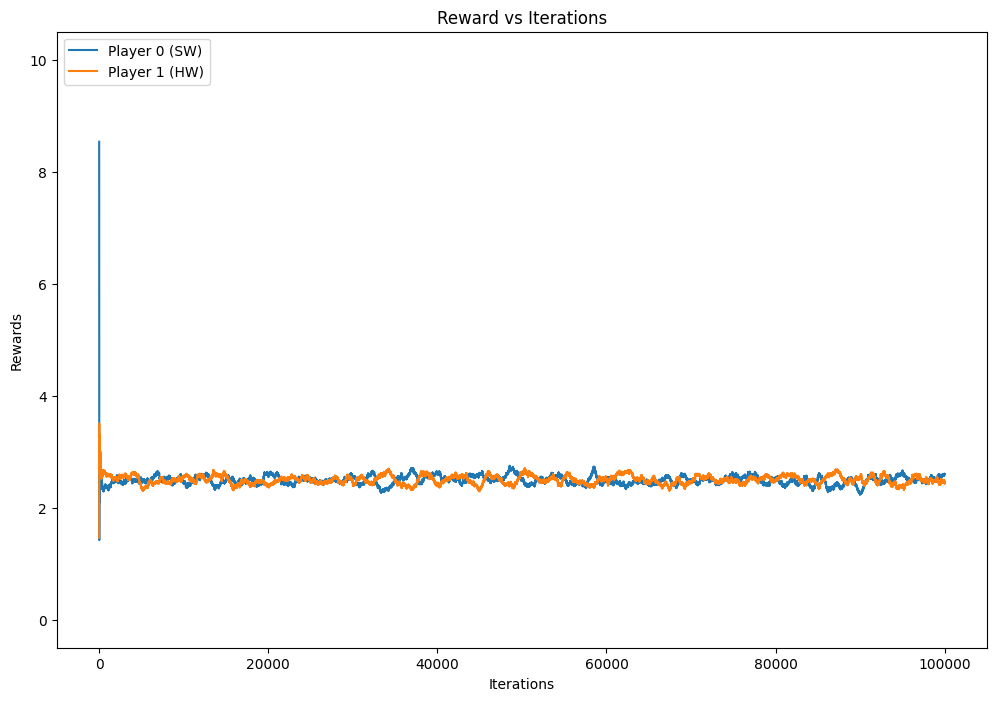

In [19]:
# Plotting
plt.figure(figsize=(12,8))
cumsum = 0
for i in range(players):
    if i!=(players-1):
        plt.plot(rewards_avg[i], label="Player {} (SW)".format(i))
    else:
        plt.plot(rewards_avg[i], label="Player {} (HW)".format(i))
    print("Average Reward of Player {} = {:.6f}.".format(i, rewards_avg[i][-1]))
    cumsum += rewards_avg[i][-1]
print("Performance over all players = {:.2f}%.".format(10 * cumsum / (players // 2)))
plt.ylim(-0.5,10.5)
plt.xlabel("Iterations")
plt.ylabel("Rewards")
plt.title("Reward vs Iterations")
plt.legend(loc="upper left")
plt.show()